In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('synthesized_student_loan_data.csv')


def calculate_repayment_months(row):
    P = row['Loan_Amount_USD']
    r = row['Interest_Rate'] / (12 * 100)  # Monthly interest rate
    PMT = row['Monthly_Installment_USD']
   
    return np.ceil(-np.log(1 - (P*r)/PMT) / np.log(1 + r))

In [3]:
df['Repayment_Months'] = df.apply(calculate_repayment_months, axis=1)

In [4]:
df['Debt_To_Income_Ratio'] = df['Monthly_Installment_USD'] / df['Monthly_Income_USD']
df['Disposable_Income'] = df['Monthly_Income_USD'] - df['Monthly_Expenses_USD']
df['Expense_Ratio'] = df['Monthly_Expenses_USD'] / df['Monthly_Income_USD']
df['Loan_To_Income_Ratio'] = df['Loan_Amount_USD'] / (df['Monthly_Income_USD'] * 12)

In [5]:
features = [
    'Loan_Amount_USD', 'Monthly_Income_USD', 'Monthly_Expenses_USD', 
    'Interest_Rate', 'Monthly_Installment_USD', 'Debt_To_Income_Ratio',
    'Disposable_Income', 'Expense_Ratio', 'Loan_To_Income_Ratio'
]

In [6]:
X = df[features]
y = df['Repayment_Months']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
def evaluate_model(y_true, y_pred, title="Model Performance"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{title}:")
    print(f"Root Mean Squared Error: {rmse:.2f} months")
    print(f"Mean Absolute Error: {mae:.2f} months")
    print(f"R² Score: {r2:.4f}")
    
    return rmse, mae, r2

In [10]:
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 21),
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [11]:
best_knn = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")


Best parameters: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}


In [12]:
y_pred_train = best_knn.predict(X_train_scaled)
y_pred_test = best_knn.predict(X_test_scaled)

In [13]:
train_metrics = evaluate_model(y_train, y_pred_train, "Training Performance")
test_metrics = evaluate_model(y_test, y_pred_test, "Test Performance")


Training Performance:
Root Mean Squared Error: 0.50 months
Mean Absolute Error: 0.49 months
R² Score: -0.0011

Test Performance:
Root Mean Squared Error: 0.49 months
Mean Absolute Error: 0.48 months
R² Score: 0.0417


In [14]:
def analyze_feature_importance(X, y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    importance_df = pd.DataFrame()
    
    for i, feature in enumerate(features):
        correlation = np.abs(np.corrcoef(X[:, i], errors)[0, 1])
        importance_df = importance_df.append({
            'Feature': feature,
            'Importance': correlation
        }, ignore_index=True)
    
    return importance_df.sort_values('Importance', ascending=False)


In [15]:
def analyze_feature_importance(X, y_true, y_pred, feature_names):
   
    # Calculate absolute prediction errors
    errors = np.abs(y_true - y_pred)
    
    # Create lists to store results
    importance_data = []
    
    # Calculate correlation between each feature and prediction error
    for i, feature in enumerate(feature_names):
        # Calculate correlation coefficient
        correlation = np.abs(np.corrcoef(X[:, i], errors)[0, 1])
        
        # Add to importance data
        importance_data.append({
            'Feature': feature,
            'Importance_Score': correlation,
            'Mean_Value': np.mean(X[:, i]),
            'Std_Dev': np.std(X[:, i]),
            'Impact_Level': 'High' if correlation > 0.5 else ('Medium' if correlation > 0.3 else 'Low')
        })
    
    # Create DataFrame from list of dictionaries
    importance_df = pd.DataFrame(importance_data)
    
    # Sort by importance score
    return importance_df.sort_values('Importance_Score', ascending=False)

In [16]:
features = [
    'Loan_Amount_USD', 
    'Monthly_Income_USD', 
    'Monthly_Expenses_USD',
    'Interest_Rate', 
    'Monthly_Installment_USD',
    'Debt_To_Income_Ratio',
    'Disposable_Income',
    'Expense_Ratio',
    'Loan_To_Income_Ratio'
]

# Calculate feature importance
feature_importance = analyze_feature_importance(X_test_scaled, y_test, y_pred_test, features)

C:\Users\neeku\AppData\Local\Temp\ipykernel_7900\2483038668.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance,


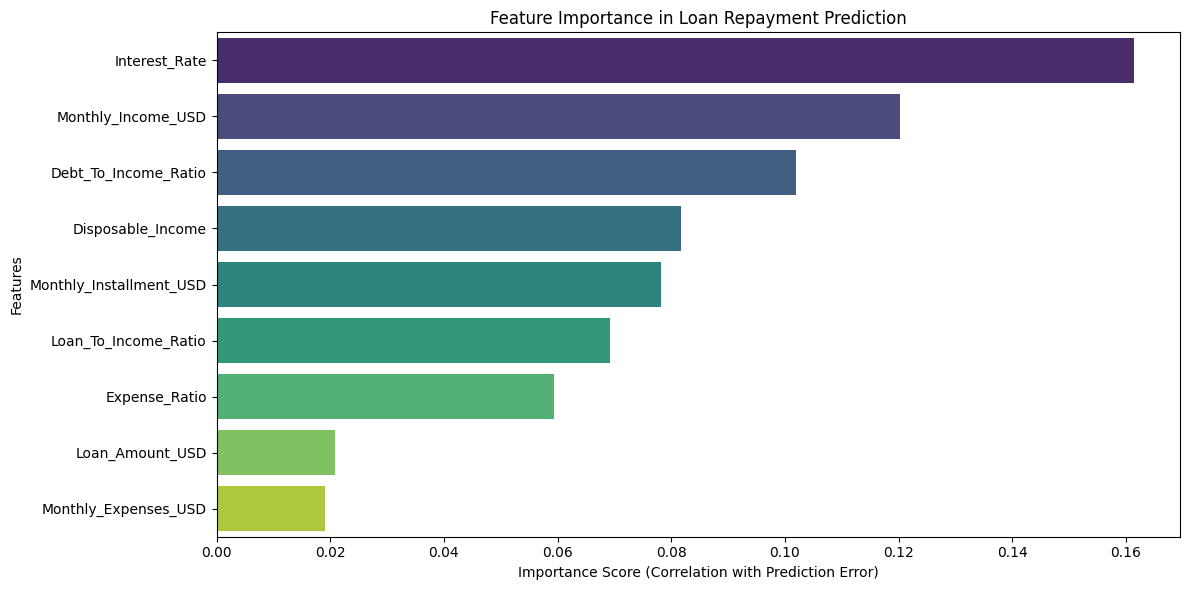

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, 
            x='Importance_Score', 
            y='Feature',
            palette='viridis')
plt.title('Feature Importance in Loan Repayment Prediction')
plt.xlabel('Importance Score (Correlation with Prediction Error)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [18]:
print("\nFeature Importance Analysis:")

for _, row in feature_importance.iterrows():
    print(f"\nFeature: {row['Feature']}")
    print(f"Importance Score: {row['Importance_Score']:.4f}")
    print(f"Impact Level: {row['Impact_Level']}")
    print(f"Mean Value: {row['Mean_Value']:.4f}")
    print(f"Standard Deviation: {row['Std_Dev']:.4f}")


Feature Importance Analysis:

Feature: Interest_Rate
Importance Score: 0.1615
Impact Level: Low
Mean Value: -0.0076
Standard Deviation: 1.1277

Feature: Monthly_Income_USD
Importance Score: 0.1202
Impact Level: Low
Mean Value: 0.0053
Standard Deviation: 0.9906

Feature: Debt_To_Income_Ratio
Importance Score: 0.1019
Impact Level: Low
Mean Value: -0.0075
Standard Deviation: 0.9719

Feature: Disposable_Income
Importance Score: 0.0817
Impact Level: Low
Mean Value: 0.1013
Standard Deviation: 0.9534

Feature: Monthly_Installment_USD
Importance Score: 0.0782
Impact Level: Low
Mean Value: 0.0194
Standard Deviation: 0.9481

Feature: Loan_To_Income_Ratio
Importance Score: 0.0692
Impact Level: Low
Mean Value: 0.0134
Standard Deviation: 0.9787

Feature: Expense_Ratio
Importance Score: 0.0593
Impact Level: Low
Mean Value: -0.1239
Standard Deviation: 0.9669

Feature: Loan_Amount_USD
Importance Score: 0.0208
Impact Level: Low
Mean Value: 0.0368
Standard Deviation: 1.0016

Feature: Monthly_Expenses_U

In [19]:
print("\nKey Insights:")

print("Top 3 Most Important Features:")
for _, row in feature_importance.head(3).iterrows():
    print(f"- {row['Feature']}: {row['Importance_Score']:.4f}")






Key Insights:
Top 3 Most Important Features:
- Interest_Rate: 0.1615
- Monthly_Income_USD: 0.1202
- Debt_To_Income_Ratio: 0.1019


In [20]:
def predict_repayment_months(input_data):
  
    input_df = pd.DataFrame([input_data])

    input_df['Debt_To_Income_Ratio'] = input_df['Monthly_Installment_USD'] / input_df['Monthly_Income_USD']
    input_df['Disposable_Income'] = input_df['Monthly_Income_USD'] - input_df['Monthly_Expenses_USD']
    input_df['Expense_Ratio'] = input_df['Monthly_Expenses_USD'] / input_df['Monthly_Income_USD']
    input_df['Loan_To_Income_Ratio'] = input_df['Loan_Amount_USD'] / (input_df['Monthly_Income_USD'] * 12)
    input_scaled = scaler.transform(input_df[features])
    prediction = best_knn.predict(input_scaled)[0]
    return round(prediction)

In [21]:
example_input = {
    'Loan_Amount_USD': 250000,
    'Monthly_Income_USD': 15000,
    'Monthly_Expenses_USD': 8000,
    'Interest_Rate': 8,
    'Monthly_Installment_USD': 5000
}

In [22]:
predicted_months = predict_repayment_months(example_input)
print(f"\nPredicted repayment months for example input: {predicted_months} months")


Predicted repayment months for example input: 120 months


In [23]:
import joblib
joblib.dump(best_knn, 'loan_repayment_knn_model.joblib')
joblib.dump(scaler, 'loan_repayment_scaler.joblib')

['loan_repayment_scaler.joblib']

In [24]:
train_metrics = evaluate_model(y_train, y_pred_train, "Training Performance")
test_metrics = evaluate_model(y_test, y_pred_test, "Test Performance")


Training Performance:
Root Mean Squared Error: 0.50 months
Mean Absolute Error: 0.49 months
R² Score: -0.0011

Test Performance:
Root Mean Squared Error: 0.49 months
Mean Absolute Error: 0.48 months
R² Score: 0.0417
